In [1]:
from mm import *

In [2]:
def query(q,url='http://85.193.83.20:8123',format=True,**kwargs):
    if format:
        return pd.read_csv(BytesIO(r.post(url=url,
                data=(q+'\nFORMAT CSVWithNames').encode('utf-8'),
                auth= (os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD'))
                ).content),**kwargs)
    
    else:
        return r.post(url=url,
                data=q.encode('utf-8'),
                auth=(os.getenv('CRYPTO_ETL_USER'),os.getenv('CRYPTO_ETL_PASSWORD')))
    

In [3]:
qq = query('''
select toStartOfInterval(toDateTime(trade_time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancews_trade
where t>'2022-01-21'
group by t
order by t

''').astype({'t':'datetime64[ms]'}).set_index('t')

In [601]:
qq2 = query('''
select toStartOfInterval(toDateTime(time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancepd_trades
where t>'2022-02-01'
group by t
order by t

''').astype({'t':'datetime64[ms]'}).set_index('t')

In [440]:
# Показывает рандомный участок графика

<AxesSubplot:xlabel='t'>

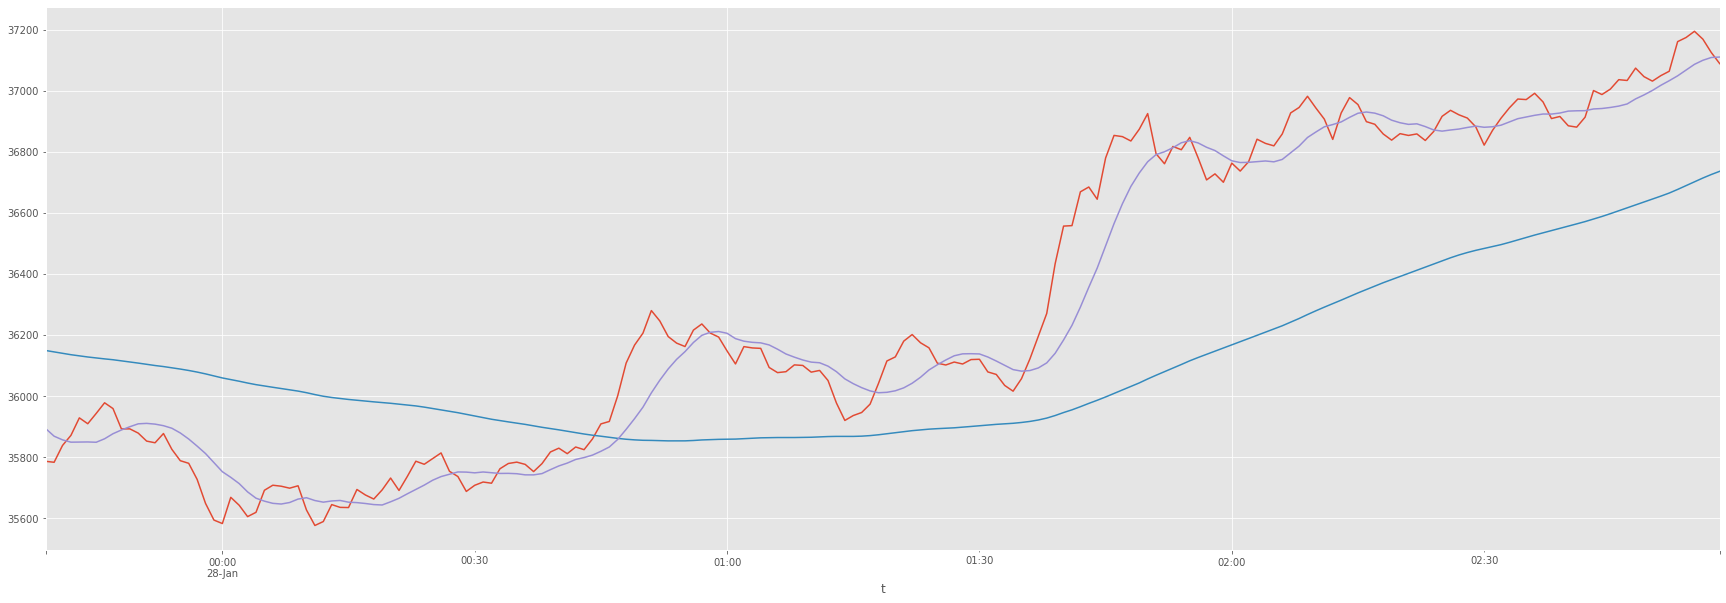

In [653]:
idx = np.random.randint(0,qq.shape[0]-200)
qq['avg_price'].iloc[idx-200:idx].plot(figsize=(30,10))
qq['avg_price'].rolling(100,1).mean().iloc[idx-200:idx].plot(figsize=(30,10))
qq['avg_price'].rolling(10,1).mean().iloc[idx-200:idx].plot(figsize=(30,10))

### В ручном режиме поиск и подбор параметров для определения крестов

In [44]:
zz = qq.copy()
zz['rolling_diff'] = (zz['avg_price'].rolling(10,1).mean() - zz['avg_price'].rolling(100,1).mean())
zz['rolling_shift'] = zz['rolling_diff'].shift(10)

In [46]:
zz['rolling_diff']

t
2022-01-21 10:56:00     0.000000
2022-01-21 10:57:00     0.000000
2022-01-21 10:58:00     0.000000
2022-01-21 10:59:00     0.000000
2022-01-21 11:00:00     0.000000
                         ...    
2022-01-31 11:30:00    67.985634
2022-01-31 11:31:00    72.193630
2022-01-31 11:32:00    74.670481
2022-01-31 11:33:00    76.726212
2022-01-31 11:34:00    79.645805
Name: rolling_diff, Length: 14429, dtype: float64

In [47]:
zz['is_buy_cross']=(zz['rolling_diff'] >0) & (zz['rolling_shift'] <0)
zz['is_sell_cross']=(zz['rolling_diff'] <0) & (zz['rolling_shift'] >0)

In [55]:
zz['price_under_roll']=(zz['avg_price'] < zz['avg_price'].rolling(10,1).mean()) 
zz['price_above_roll']=(zz['avg_price'] > zz['avg_price'].rolling(10,1).mean())

<AxesSubplot:xlabel='t'>

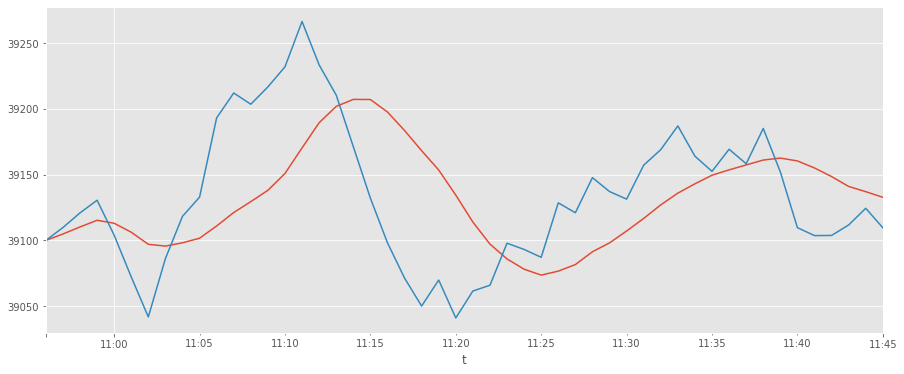

In [70]:
zz['avg_price'].rolling(10,1).mean().iloc[:50].plot()
zz['avg_price'].iloc[:50].plot()

In [65]:
zz

,trades_count,avg_price,rolling_diff,rolling_shift,is_buy_cross,is_sell_cross,price_under_roll,price_above_roll
t,,,,,,,,
2022-01-21 10:56:00,469,39100.022623,0.000000,NaN,False,False,False,False
2022-01-21 10:57:00,903,39109.787065,0.000000,NaN,False,False,False,True
2022-01-21 10:58:00,787,39120.925464,0.000000,NaN,False,False,False,True
2022-01-21 10:59:00,809,39130.568443,0.000000,NaN,False,False,False,True
2022-01-21 11:00:00,1285,39104.008817,0.000000,NaN,False,False,True,False
...,...,...,...,...,...,...,...,...
2022-01-31 11:30:00,493,37173.183164,67.985634,97.352985,False,False,False,True
2022-01-31 11:31:00,830,37180.344747,72.193630,90.993767,False,False,False,True
2022-01-31 11:32:00,474,37176.091371,74.670481,86.049308,False,False,False,True


In [61]:
zz.assign(r10=zz['avg_price'].rolling(10,1).mean()).where(lambda x: (x['is_buy_cross']>0) & (x['price_under_roll']>0)).dropna()

,trades_count,avg_price,rolling_diff,rolling_shift,is_buy_cross,is_sell_cross,price_under_roll,price_above_roll,r10
t,,,,,,,,,
2022-01-21 11:39:00,870.0,39152.079138,26.570528,-30.066648,True,False,True,False,39162.591879
2022-01-21 11:40:00,959.0,39109.718144,24.987751,-21.127832,True,False,True,False,39160.424586
2022-01-21 11:41:00,548.0,39103.693120,20.327938,-12.369073,True,False,True,False,39155.074692
2022-01-21 11:42:00,680.0,39103.803574,14.467098,-3.143169,True,False,True,False,39148.555487
2022-01-21 12:01:00,1105.0,39134.600226,17.054292,-29.619561,True,False,True,False,39148.407420
...,...,...,...,...,...,...,...,...,...
2022-01-31 05:29:00,668.0,36892.731946,52.177383,-33.057099,True,False,True,False,36911.192574
2022-01-31 05:30:00,572.0,36882.485385,51.736831,-16.912911,True,False,True,False,36910.292571
2022-01-31 10:27:00,306.0,37027.126699,27.940582,-32.037026,True,False,True,False,37029.415920


In [75]:
idxs = zz.where(lambda x: (x['is_buy_cross']>0) & (x['price_under_roll']>0)).dropna().index

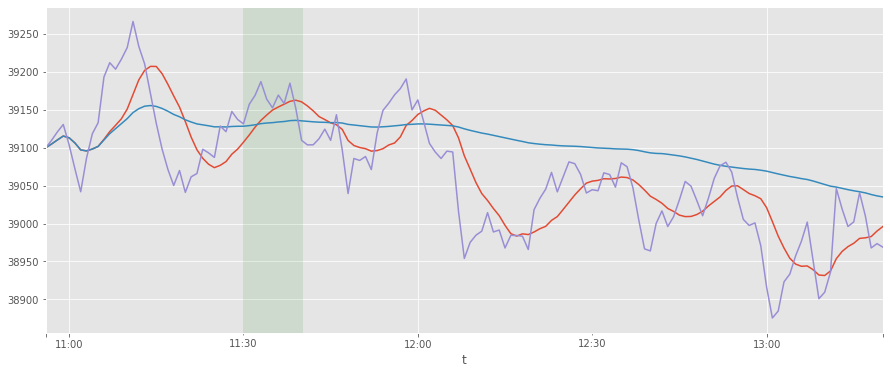

In [73]:
idx = idxs[1]
zz['avg_price'].rolling(10,1).mean().loc[idx - pd.Timedelta(100,'min'):idx + pd.Timedelta(100,'min')].plot()
zz['avg_price'].rolling(100,1).mean().loc[idx - pd.Timedelta(100,'min'):idx + pd.Timedelta(100,'min')].plot()
zz.loc[idx - pd.Timedelta(100,'min'):idx + pd.Timedelta(100,'min'),'avg_price'].plot()
plt.axvspan(idx - pd.Timedelta(10,'min'),idx,color='green',alpha=.1)

In [442]:
# Поиск дельты, через сколько продавать

In [76]:
rng_idx = np.random.randint(0,zz.shape[0]-500)
test_df = zz['avg_price'].iloc[rng_idx:rng_idx+500]
buy_values = zz.loc[idxs]['avg_price'].rename('cross_buy')

In [77]:
check_profits = []
for i in tqdm(range(5000)):
    rng_idx = np.random.randint(0,zz.shape[0]-500)
    buy_values = zz.loc[idxs]['avg_price'].rename('cross_buy')
    test_df = zz['avg_price'].iloc[rng_idx:rng_idx+500]
    try:
        profits = [test_df.shift(-i).sub(buy_values).sum() for i in range(1,20)]
        check_profits.append(profits)
    except:
        pass

100%|██████████| 5000/5000 [00:48<00:00, 103.48it/s]


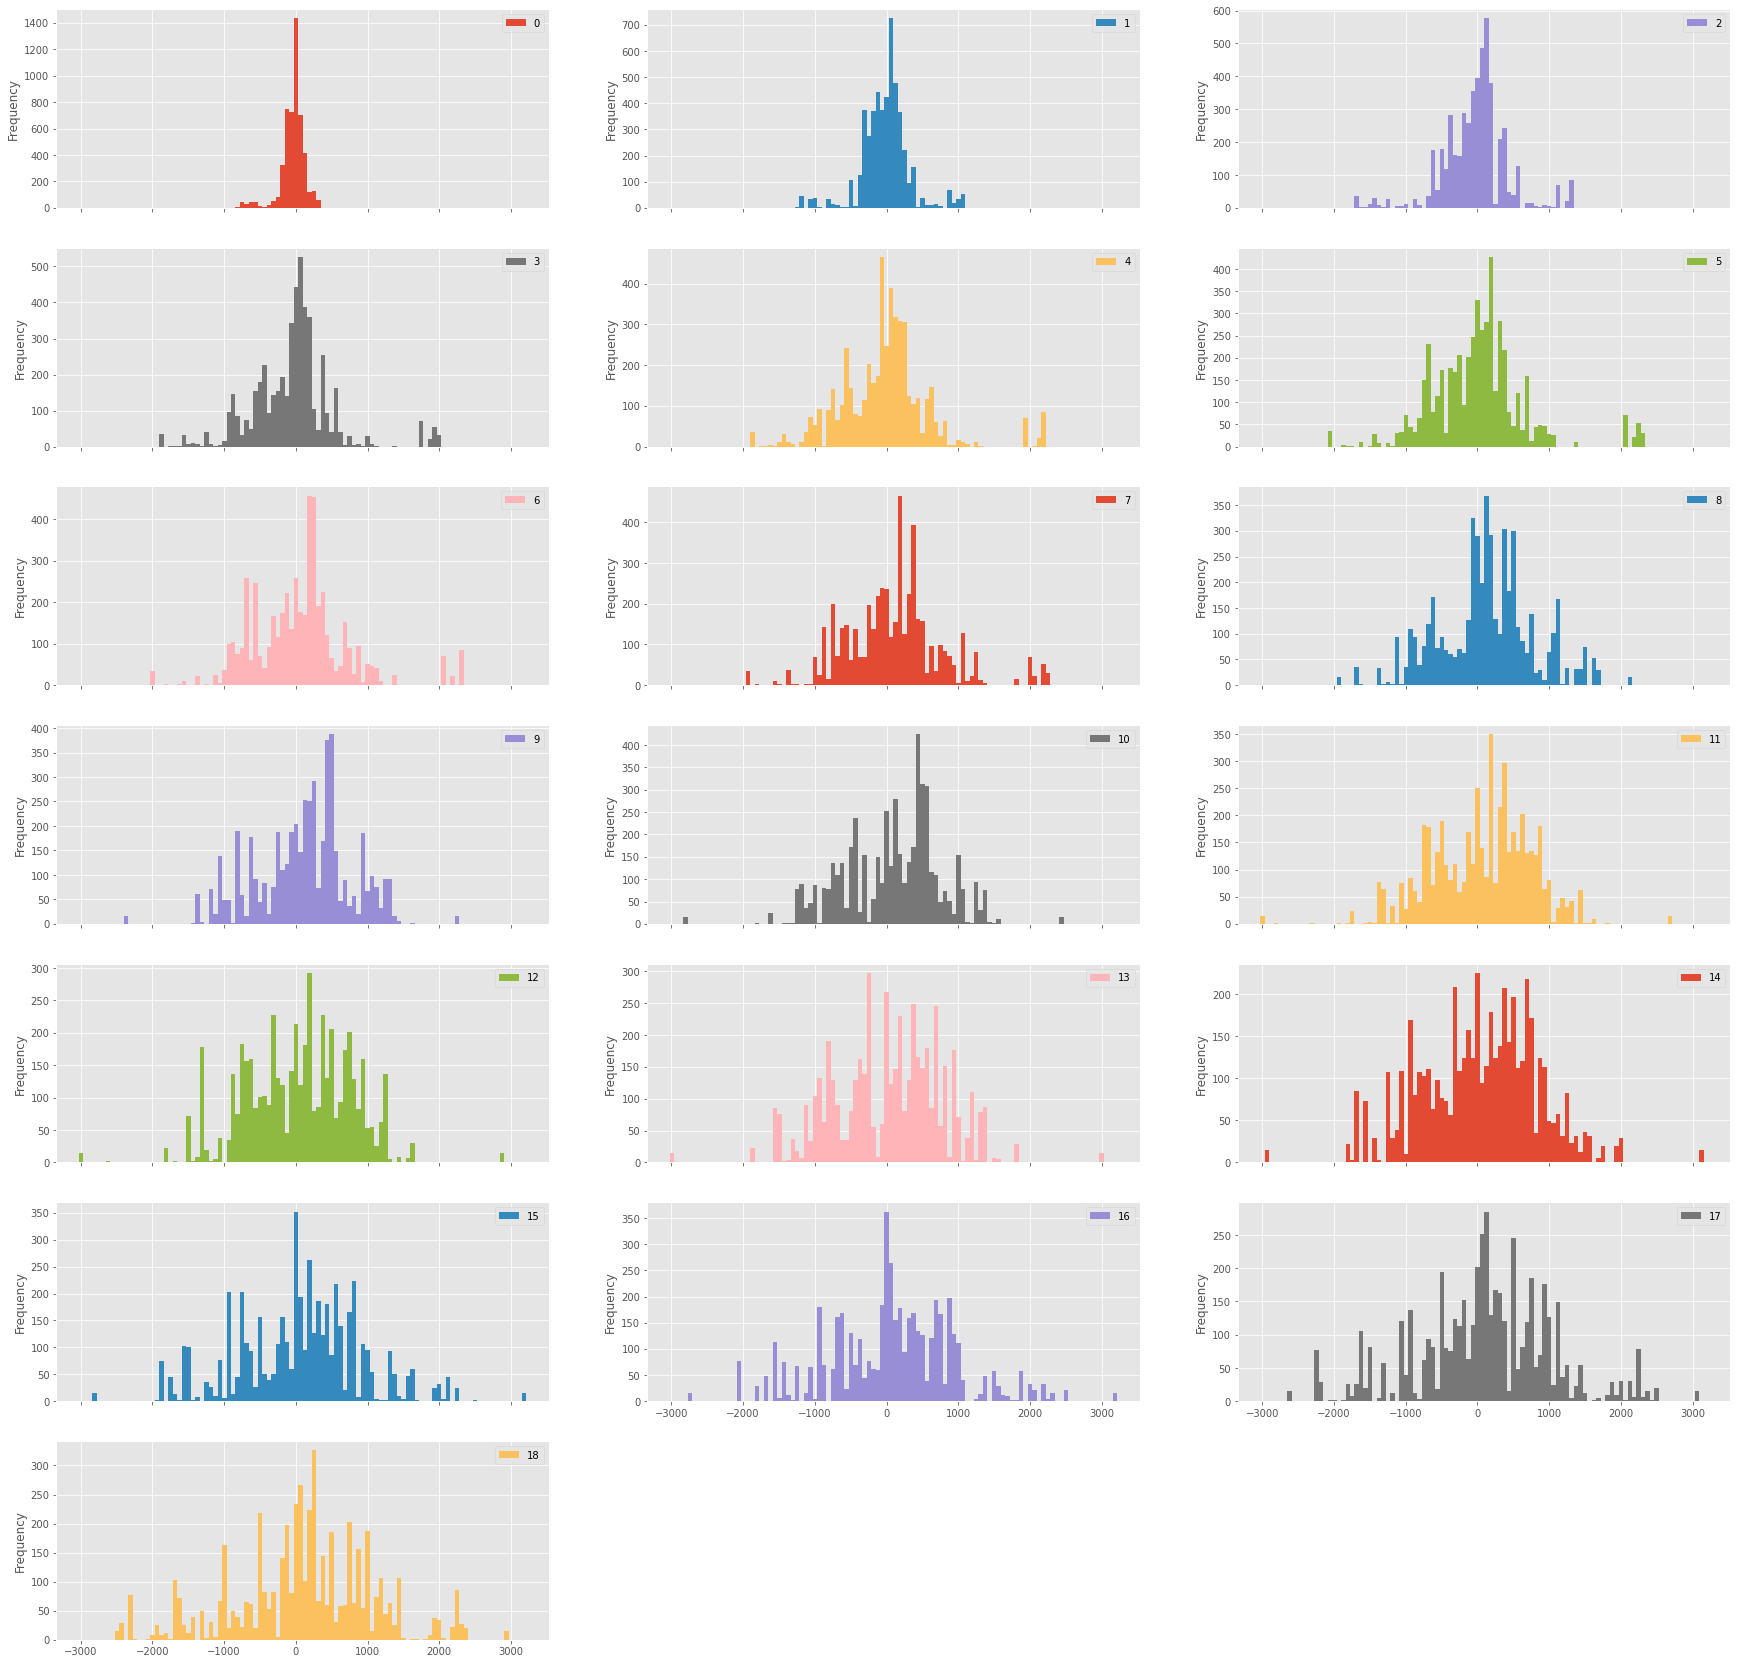

In [78]:
pd.DataFrame(check_profits).plot.hist(subplots=True,bins=100,layout=(-1,3),figsize=(30,30));

In [82]:
pd.DataFrame(check_profits).mean().T.idxmax()

8

<AxesSubplot:xlabel='t'>

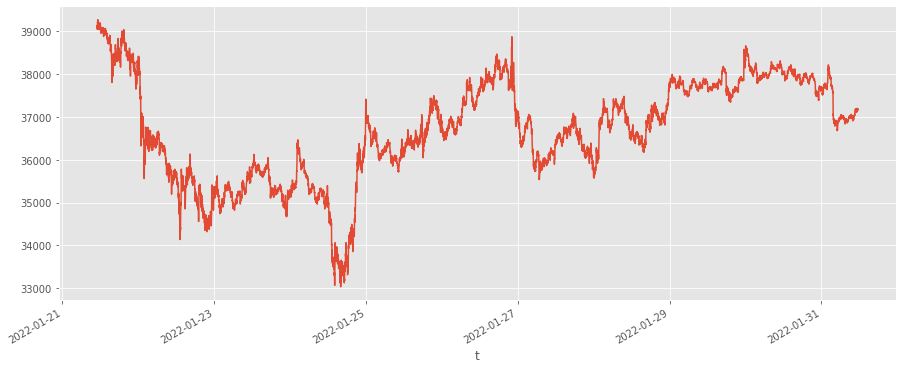

In [86]:
zz['avg_price'].plot()

<AxesSubplot:xlabel='t'>

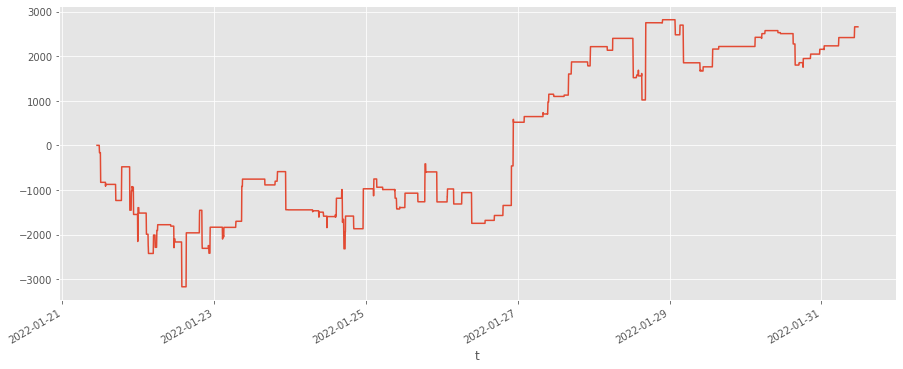

In [84]:
zz['avg_price'].shift(-8).sub(buy_values).fillna(0).cumsum().plot()

### (Почти) Человеческое оформление в функции

In [134]:
def find_best_sell_time (data,buy_idxs,test_df_length=500,n_bootstraps=1000):
    profits_chickpoinst = []
    for _ in range(n_bootstraps):
        rng_idx = np.random.randint(0,data.shape[0]-test_df_length)
        test_df = data.iloc[rng_idx:rng_idx+test_df_length]
        deals_index = set(buy_idxs) & set(test_df.index)
        n_deals = len(deals_index)
        if n_deals>0:
            buy_values = test_df.loc[deals_index].rename('cross_buy')
            profits = [test_df.shift(-i).sub(buy_values).sum() for i in range(1,20)]
            profits_chickpoinst.append(profits)
        else:
            profits_chickpoinst.append(np.zeros(20))
    n_shift_sell = pd.DataFrame(profits_chickpoinst).mean().T.idxmax()
    # pd.DataFrame(profits_chickpoinst).mean().plot.bar()
    return n_shift_sell

In [140]:
def bootstrap_value_gain(data,buy_idxs,sell_shift=11,test_df_length=500,n_bootstraps=1000):
    check_profits = []
    for i in tqdm(range(n_bootstraps)):
        rng_idx = np.random.randint(0,data.shape[0]-test_df_length)
        test_df = data.iloc[rng_idx:rng_idx+test_df_length]
        deals_index = set(buy_idxs) & set(test_df.index)
        n_deals = len(deals_index)
        if n_deals>0:
            buy_values = test_df.loc[deals_index].rename('cross_buy')
            profits = [test_df.shift(-sell_shift).sub(buy_values).sum(),\
                        test_df.shift(-sell_shift).sub(test_df.sample(n_deals)).sum(), 
                        (test_df.iloc[-1] - test_df.sample(n_deals)).sum() ]
            check_profits.append(profits)
        else:
            pass
    return pd.DataFrame(check_profits,columns=['strategy','random_buy_sell','hodl'])

In [136]:
# Итоговая функция для поиска, тестирования стратегии
# По итогу выдает набутстрепленные данные по стратегиям + даты , когда покупать

In [148]:
def check_cross(data,value_col ='avg_price' ,cross_area='10min',rolling_fast =10,rolling_long = 100,value_gain_check=True,**kwargs ):
    zz = data.copy()
    
    zz['rolling_diff'] = (zz[value_col].rolling(rolling_fast,1).mean() - zz[value_col].rolling(rolling_long,1).mean()).shift(-1)
    zz['rolling_shift'] = zz['rolling_diff'].shift(10)

    zz['is_buy_cross']=(zz['rolling_diff'] >0) & (zz['rolling_shift'] <0)
    zz['is_sell_cross']=(zz['rolling_diff'] <0) & (zz['rolling_shift'] >0)
    
    zz['price_under_roll']=(zz[value_col] < zz[value_col].rolling(rolling_fast,1).mean()) & (zz[value_col] < zz[value_col].rolling(rolling_long,1).mean())
    zz['price_above_roll']=(zz[value_col] > zz[value_col].rolling(rolling_fast,1).mean()) & (zz[value_col] > zz[value_col].rolling(rolling_long,1).mean())

    idxs = zz.where(lambda x: (x['is_buy_cross']>0) & (x['price_under_roll']>0)).dropna().index
    sell_shift = find_best_sell_time(zz[value_col],idxs,**kwargs)
    print(f'Sell shift timeout is {sell_shift}')
    if value_gain_check:
        result = bootstrap_value_gain(data=zz[value_col],buy_idxs=idxs,sell_shift = sell_shift,**kwargs)
        return idxs,sell_shift,result
    else :
        return idxs,sell_shift

### Тестирование

In [168]:
deals_datetime,sell_shift = check_cross(qq[['avg_price']],'avg_price',rolling_fast=25,rolling_long=100,value_gain_check=False,n_bootstraps=1000)

Sell shift timeout is 12


In [145]:
df.agg(['mean','sum'])

,strategy,random_buy_sell,hodl
mean,549.999721,-65.472680,-816.533809
sum,312399.841424,-37188.481977,-463791.203255


100%|██████████| 100/100 [00:05<00:00, 18.68it/s]


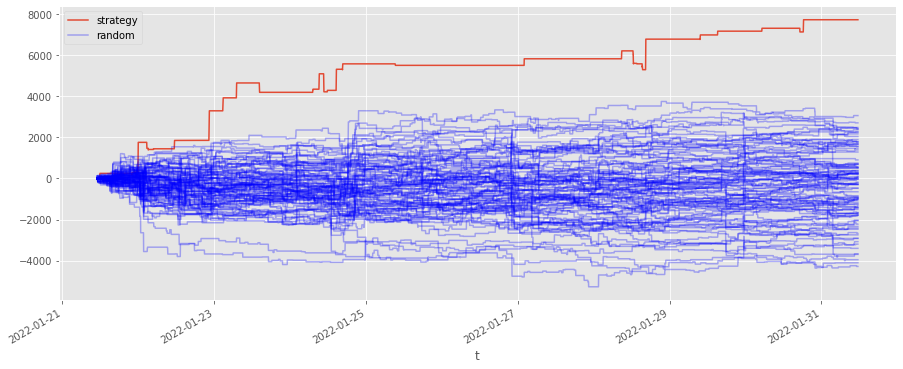

In [169]:

qq['avg_price'].shift(-sell_shift).sub(qq['avg_price'].loc[deals_datetime]).fillna(0).cumsum().plot()
[qq['avg_price'].shift(-sell_shift).sub(qq['avg_price'].sample(deals_datetime.shape[0])).fillna(0).cumsum().plot(color='b',alpha=.3) for _ in tqdm(range(100))]
plt.legend(['strategy','random'])

In [115]:
qq3 = query('''
select toStartOfInterval(toDateTime(time/1000), interval 1 minute) as t, 
count(trade_id)  trades_count,
avg(price)  as avg_price
from crypto.binancepd_trades
where toDate(time) > today() - 30
group by t
order by t

''').astype({'t':'datetime64[ms]'}).set_index('t')

In [170]:
deals_datetime,shift_,df = check_cross(qq3[['avg_price']],'avg_price',rolling_fast=25,rolling_long=100,n_bootstraps=1000,value_gain_check=True)

Sell shift timeout is 15


100%|██████████| 1000/1000 [00:04<00:00, 211.53it/s]


<AxesSubplot:xlabel='t'>

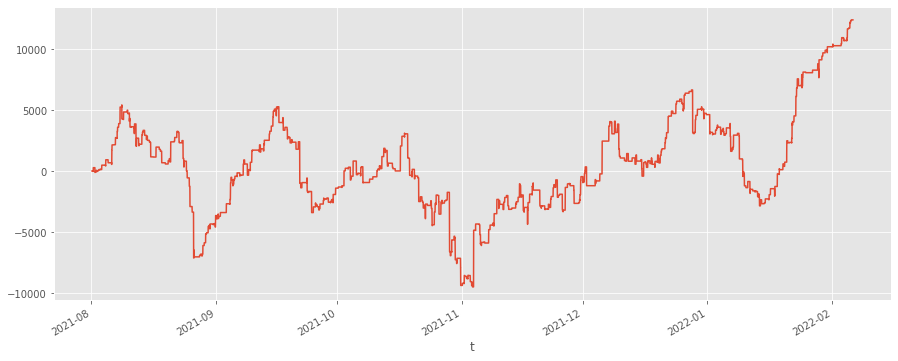

In [174]:
qq3['avg_price'].shift(-shift_).sub(qq3['avg_price'].loc[deals_datetime]).fillna(0).cumsum().plot()


In [178]:
qq3['avg_price']

t
2021-08-01 03:00:00    41447.734284
2021-08-01 03:01:00    41332.737063
2021-08-01 03:02:00    41203.095274
2021-08-01 03:03:00    41209.946217
2021-08-01 03:04:00    41315.180441
                           ...     
2022-02-06 02:55:00    41398.833294
2022-02-06 02:56:00    41402.090354
2022-02-06 02:57:00    41398.439769
2022-02-06 02:58:00    41420.431344
2022-02-06 02:59:00    41401.399614
Name: avg_price, Length: 271770, dtype: float64

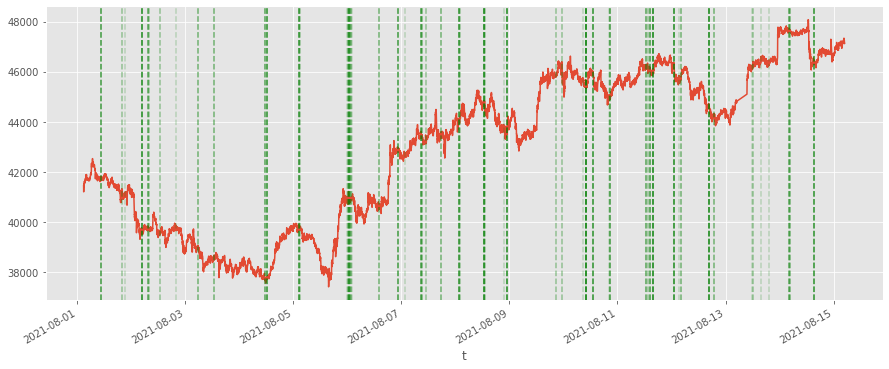

In [194]:
qq3['avg_price'].iloc[:20000].plot()
[plt.axvline(i,color='g',alpha=.2,linestyle='--') for i in deals_datetime[:200]];

100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


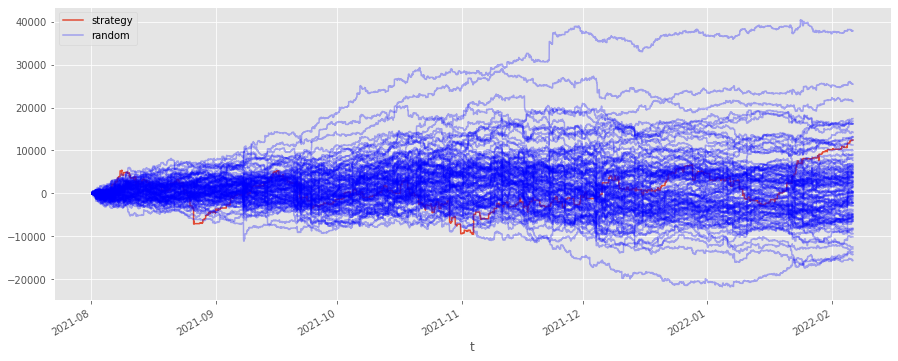

In [171]:
qq3['avg_price'].shift(-shift_).sub(qq3['avg_price'].loc[deals_datetime]).fillna(0).cumsum().plot()
[qq3['avg_price'].shift(-shift_).sub(qq3['avg_price'].sample(deals_datetime.shape[0])).fillna(0).cumsum().plot(color='b',alpha=.3) for _ in tqdm(range(100))]
plt.legend(['strategy','random'])

In [162]:
new_data = pd.DataFrame()
for i in range(5,50,5):
    for j in range(50,300,50):
        new_data.loc[i,j] = check_cross(qq3[['avg_price']],'avg_price',rolling_fast=i,rolling_long=j,n_bootstraps=500,value_gain_check=True)[2]['strategy'].median()
        print(new_data)

Sell shift timeout is 6


100%|██████████| 500/500 [00:02<00:00, 167.84it/s]


          50
5  10.853604
Sell shift timeout is 5


100%|██████████| 500/500 [00:02<00:00, 211.42it/s]


         50        100
5  10.853604  16.60272
Sell shift timeout is 7


100%|██████████| 500/500 [00:02<00:00, 238.44it/s]


         50        100       150
5  10.853604  16.60272  2.693893
Sell shift timeout is 6


100%|██████████| 500/500 [00:01<00:00, 257.46it/s]


         50        100       150  200
5  10.853604  16.60272  2.693893  0.0
Sell shift timeout is 8


100%|██████████| 500/500 [00:01<00:00, 267.37it/s]


         50        100       150  200        250
5  10.853604  16.60272  2.693893  0.0  17.221014
Sell shift timeout is 18


100%|██████████| 500/500 [00:03<00:00, 142.08it/s]


          50        100       150  200        250
5   10.853604  16.60272  2.693893  0.0  17.221014
10  23.790142       NaN       NaN  NaN        NaN
Sell shift timeout is 19


100%|██████████| 500/500 [00:02<00:00, 187.90it/s]


          50         100       150  200        250
5   10.853604  16.602720  2.693893  0.0  17.221014
10  23.790142  50.102553       NaN  NaN        NaN
Sell shift timeout is 19


100%|██████████| 500/500 [00:02<00:00, 209.64it/s]


          50         100        150  200        250
5   10.853604  16.602720   2.693893  0.0  17.221014
10  23.790142  50.102553  25.556048  NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:02<00:00, 233.85it/s]


          50         100        150  200        250
5   10.853604  16.602720   2.693893  0.0  17.221014
10  23.790142  50.102553  25.556048  0.0        NaN
Sell shift timeout is 7


100%|██████████| 500/500 [00:01<00:00, 257.27it/s]


          50         100        150  200        250
5   10.853604  16.602720   2.693893  0.0  17.221014
10  23.790142  50.102553  25.556048  0.0  22.856575
Sell shift timeout is 18


100%|██████████| 500/500 [00:06<00:00, 79.38it/s] 


           50         100        150  200        250
5    10.853604  16.602720   2.693893  0.0  17.221014
10   23.790142  50.102553  25.556048  0.0  22.856575
15  120.955884        NaN        NaN  NaN        NaN
Sell shift timeout is 16


100%|██████████| 500/500 [00:02<00:00, 201.67it/s]


           50         100        150  200        250
5    10.853604  16.602720   2.693893  0.0  17.221014
10   23.790142  50.102553  25.556048  0.0  22.856575
15  120.955884  93.973111        NaN  NaN        NaN
Sell shift timeout is 17


100%|██████████| 500/500 [00:02<00:00, 227.45it/s]


           50         100        150  200        250
5    10.853604  16.602720   2.693893  0.0  17.221014
10   23.790142  50.102553  25.556048  0.0  22.856575
15  120.955884  93.973111  60.172959  NaN        NaN
Sell shift timeout is 19


100%|██████████| 500/500 [00:01<00:00, 282.91it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299        NaN
Sell shift timeout is 16


100%|██████████| 500/500 [00:01<00:00, 309.26it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
Sell shift timeout is 18


100%|██████████| 500/500 [00:03<00:00, 134.85it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
20   44.236341        NaN        NaN        NaN        NaN
Sell shift timeout is 14


100%|██████████| 500/500 [00:02<00:00, 207.86it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
20   44.236341  67.909019        NaN        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:02<00:00, 228.25it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
20   44.236341  67.909019   0.000000        NaN        NaN
Sell shift timeout is 13


100%|██████████| 500/500 [00:01<00:00, 300.66it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
20   44.236341  67.909019   0.000000  61.099868        NaN
Sell shift timeout is 19


100%|██████████| 500/500 [00:01<00:00, 326.58it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
20   44.236341  67.909019   0.000000  61.099868  27.608044
Sell shift timeout is 16


100%|██████████| 500/500 [00:04<00:00, 123.56it/s]


           50         100        150        200        250
5    10.853604  16.602720   2.693893   0.000000  17.221014
10   23.790142  50.102553  25.556048   0.000000  22.856575
15  120.955884  93.973111  60.172959  37.536299  14.904087
20   44.236341  67.909019   0.000000  61.099868  27.608044
25  133.157123        NaN        NaN        NaN        NaN
Sell shift timeout is 16


100%|██████████| 500/500 [00:02<00:00, 224.12it/s]


           50          100        150        200        250
5    10.853604   16.602720   2.693893   0.000000  17.221014
10   23.790142   50.102553  25.556048   0.000000  22.856575
15  120.955884   93.973111  60.172959  37.536299  14.904087
20   44.236341   67.909019   0.000000  61.099868  27.608044
25  133.157123  106.992780        NaN        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 250.36it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 325.73it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 326.58it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
Sell shift timeout is 18


100%|██████████| 500/500 [00:07<00:00, 68.15it/s] 


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783         NaN         NaN        NaN        NaN
Sell shift timeout is 16


100%|██████████| 500/500 [00:02<00:00, 208.16it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079         NaN        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 266.36it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 352.48it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 330.03it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
Sell shift timeout is 14


100%|██████████| 500/500 [00:04<00:00, 102.26it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628         NaN         NaN        NaN        NaN
Sell shift timeout is 19


100%|██████████| 500/500 [00:02<00:00, 207.26it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222         NaN        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 294.46it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826        NaN        NaN
Sell shift timeout is 12


100%|██████████| 500/500 [00:01<00:00, 358.94it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976        NaN
Sell shift timeout is 9


100%|██████████| 500/500 [00:01<00:00, 331.35it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
Sell shift timeout is 19


100%|██████████| 500/500 [00:05<00:00, 89.61it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176         NaN         NaN        NaN        NaN
Sell shift timeout is 7


100%|██████████| 500/500 [00:02<00:00, 200.99it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991         NaN        NaN        NaN
Sell shift timeout is 14


100%|██████████| 500/500 [00:01<00:00, 310.36it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616        NaN        NaN
Sell shift timeout is 11


100%|██████████| 500/500 [00:01<00:00, 314.27it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 381.10it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543 -34.307265
Sell shift timeout is 19


100%|██████████| 500/500 [00:08<00:00, 56.48it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543 -34.307265
45   28.277814         NaN         NaN        NaN        NaN
Sell shift timeout is 6


100%|██████████| 500/500 [00:02<00:00, 203.67it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543 -34.307265
45   28.277814   49.774845         NaN        NaN        NaN
Sell shift timeout is 15


100%|██████████| 500/500 [00:01<00:00, 311.71it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543 -34.307265
45   28.277814   49.774845   22.527958        NaN        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 393.08it/s]


           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543 -34.307265
45   28.277814   49.774845   22.527958   6.661262        NaN
Sell shift timeout is 18


100%|██████████| 500/500 [00:01<00:00, 397.14it/s]

           50          100         150        200        250
5    10.853604   16.602720    2.693893   0.000000  17.221014
10   23.790142   50.102553   25.556048   0.000000  22.856575
15  120.955884   93.973111   60.172959  37.536299  14.904087
20   44.236341   67.909019    0.000000  61.099868  27.608044
25  133.157123  106.992780  100.341653  43.272066  54.142220
30  167.109783  103.512079   82.874402  67.546820   5.720066
35   74.060628   38.358222   75.790826  28.415976  69.527062
40   66.802176   59.100991   46.754616  -1.040543 -34.307265
45   28.277814   49.774845   22.527958   6.661262  79.019328


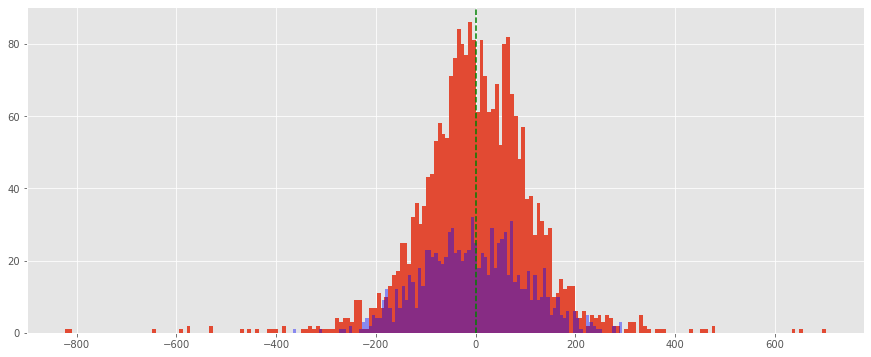

In [158]:
qq3['avg_price'].shift(-shift_).sub(qq3['avg_price'].loc[deals_datetime]).dropna().hist(bins=200)
plt.hist(np.random.normal(0,100,1000),bins=100,color='blue',alpha=.4);
plt.axvline(0,linestyle='--',color='g')